In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



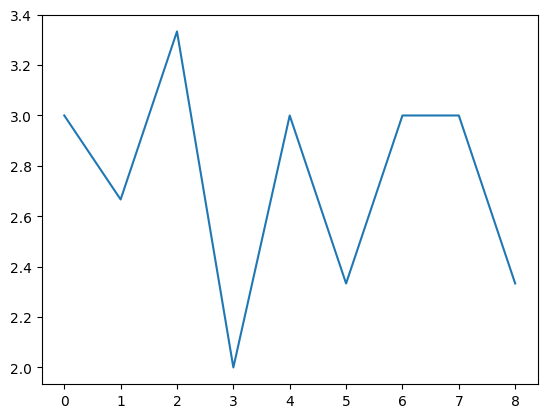

In [11]:
test_interval = 10

mean_attack_hares_list = []
for test_ind in range(1, 10):
    epoch = int(test_ind * test_interval)
    df = pd.read_csv(f'../data/staghunt_small_room_\
size3_regen1_v2_test_interval10/unit_test/probe_test_epoch_{epoch}_group.csv')
    mean_attack_hares = df['attacks_to_hares'].mean()
    mean_attack_hares_list.append(mean_attack_hares)

plt.plot(mean_attack_hares_list)

